In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline 

In [2]:
import importlib
import ids_common
importlib.reload(ids_common)

<module 'ids_common' from 'd:\\stuff\\univ\\ids\\ids_common.py'>

In [3]:
SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

#TODO: rename to detection_class and classification_class
target_label_2_class = 'Attack_label' # 0 indicates normal and 1 indicates attacks
target_label_15_class = 'Attack_type'

def ds_detection_split(dataset):
    """"Normal vs Attack"""
    y = dataset[target_label_2_class]
    X = dataset.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

def ds_split(dataset):
    """Simple split, stratify against Attack_type"""
    return train_test_split(dataset, test_size=0.2, random_state=SEED, stratify=dataset[target_label_15_class])

def ds_classification_split(dataset):
    """Split on Attack_type"""
    loc_df = dataset.drop(dataset[dataset[target_label_2_class] == 0].index, inplace=False)
    y = loc_df[target_label_15_class]
    X = loc_df.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

SEED = 42


In [9]:
df = pd.read_csv('./sampled_data/sample_1/clean_dataset.csv', low_memory=False)

df['Attack_type'] = df['Attack_type'].astype('category')

for col in df.columns:
    if df[col].dtype == 'object':
        ids_common.encode_text_dummy(df, col)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3427020 entries, 0 to 3427019
Data columns (total 63 columns):
 #   Column                               Dtype   
---  ------                               -----   
 0   arp.opcode                           float64 
 1   arp.hw.size                          float64 
 2   icmp.checksum                        float64 
 3   icmp.seq_le                          float64 
 4   icmp.unused                          float64 
 5   http.content_length                  float64 
 6   http.response                        float64 
 7   http.tls_port                        float64 
 8   tcp.ack                              float64 
 9   tcp.ack_raw                          float64 
 10  tcp.checksum                         float64 
 11  tcp.connection.fin                   float64 
 12  tcp.connection.rst                   float64 
 13  tcp.connection.syn                   float64 
 14  tcp.connection.synack                float64 
 15  tcp.flags      

In [10]:
df_train_global, df_test_global = ds_split(df)
print(f'df_train_global={df_train_global.shape}')
print(f'df_test_global={df_test_global.shape}')

X_train_detection, X_test_detection, y_train_detection, y_test_detection = ds_detection_split(df_train_global)
print(f'X_train_detection={X_train_detection.shape} y_train_detection={y_train_detection.shape}')
print(f'X_test_detection={X_test_detection.shape}   y_test_detection={y_test_detection.shape}')

X_train_classification, X_test_classification, y_train_classification, y_test_classification = ds_classification_split(df_train_global)
print(f'X_train_classification={X_train_classification.shape} y_train_classification={y_train_classification.shape}')
print(f'X_test_classification={X_test_classification.shape}   y_test_classification={y_test_classification.shape}')

df_train_global=(2741616, 63)
df_test_global=(685404, 63)
X_train_detection=(2193292, 61) y_train_detection=(2193292,)
X_test_detection=(548324, 61)   y_test_detection=(548324,)
X_train_classification=(812684, 61) y_train_classification=(812684,)
X_test_classification=(203171, 61)   y_test_classification=(203171,)


TRAIN:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1380608
           1       0.99      0.98      0.99    812684

    accuracy                           0.99   2193292
   macro avg       0.99      0.99      0.99   2193292
weighted avg       0.99      0.99      0.99   2193292

TEST:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    345153
           1       0.92      0.92      0.92    203171

    accuracy                           0.94    548324
   macro avg       0.93      0.93      0.93    548324
weighted avg       0.94      0.94      0.94    548324



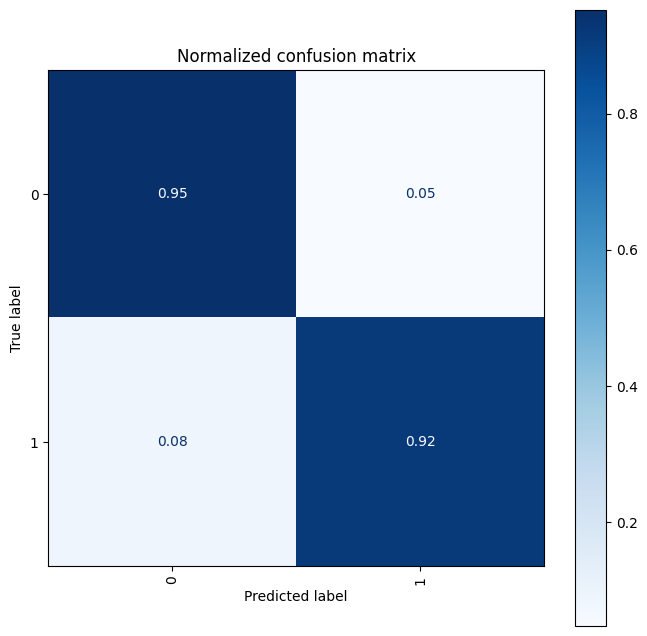

In [11]:
detector = DecisionTreeClassifier(random_state=SEED)

detector.fit(X_train_detection, y_train_detection)
y_train_detection_predict = detector.predict(X_train_detection)
y_test_detection_predict = detector.predict(X_test_detection)

ids_common.report(y_train_detection, 
       y_train_detection_predict, 
       y_test_detection,
       y_test_detection_predict)

ids_common.plot_cm(y_test_detection, y_test_detection_predict)

TRAIN:
                       precision    recall  f1-score   support

             Backdoor       0.98      1.00      0.99     15377
            DDoS_HTTP       0.92      1.00      0.96     68999
            DDoS_ICMP       1.00      1.00      1.00     63786
             DDoS_TCP       1.00      1.00      1.00    129278
             DDoS_UDP       1.00      1.00      1.00    204893
                 MITM       1.00      1.00      1.00       230
    OS_Fingerprinting       0.94      0.95      0.95       546
             Password       0.99      0.98      0.99    198266
        Port_Scanning       1.00      1.00      1.00     12785
           Ransomware       1.00      0.98      0.99      6201
        SQL_injection       0.99      0.97      0.98     32529
            Uploading       1.00      0.91      0.95     23556
Vulnerability_scanner       1.00      1.00      1.00     46596
                  XSS       1.00      0.96      0.98      9642

             accuracy                         

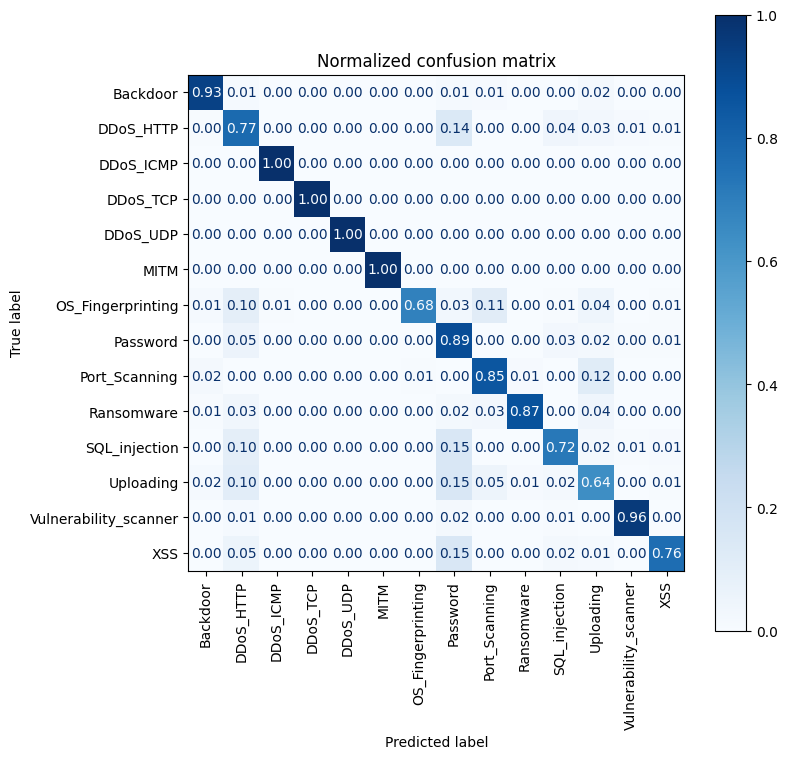

In [12]:
classifier = DecisionTreeClassifier(random_state=SEED)

classifier.fit(X_train_classification, y_train_classification)
y_train_classification_predict = classifier.predict(X_train_classification)
y_test_classification_predict = classifier.predict(X_test_classification)

ids_common.report(y_train_classification, 
       y_train_classification_predict, 
       y_test_classification,
       y_test_classification_predict)

ids_common.plot_cm(y_test_classification, y_test_classification_predict)

DETECTION:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    431440
           1       0.92      0.92      0.92    253964

    accuracy                           0.94    685404
   macro avg       0.94      0.93      0.93    685404
weighted avg       0.94      0.94      0.94    685404



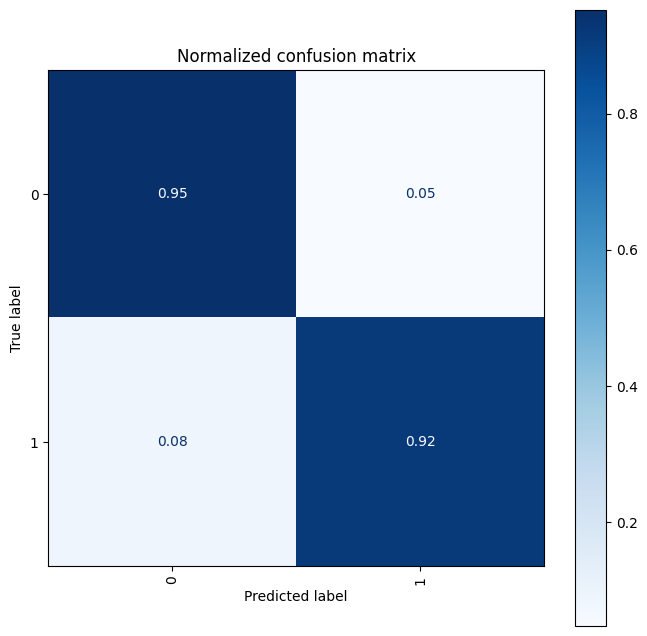

CLASSIFICATION:
                       precision    recall  f1-score   support

             Backdoor       0.92      0.93      0.93      4805
            DDoS_HTTP       0.69      0.71      0.70     21562
            DDoS_ICMP       1.00      1.00      1.00     19933
             DDoS_TCP       1.00      1.00      1.00     40399
             DDoS_UDP       1.00      1.00      1.00     64029
                 MITM       1.00      1.00      1.00        72
               Normal       0.95      0.95      0.95    431440
    OS_Fingerprinting       0.69      0.66      0.68       171
             Password       0.78      0.77      0.78     61958
        Port_Scanning       0.87      0.86      0.87      3996
           Ransomware       0.90      0.89      0.89      1938
        SQL_injection       0.70      0.69      0.70     10165
            Uploading       0.67      0.63      0.65      7362
Vulnerability_scanner       0.96      0.96      0.96     14561
                  XSS       0.78      

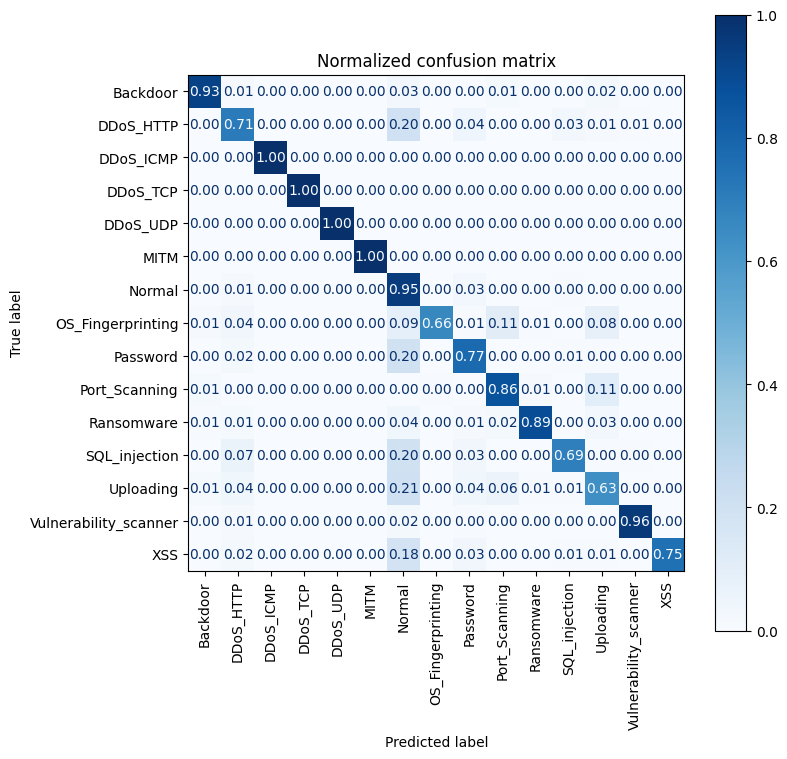

In [14]:
y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)


y_global_detection_predict = detector.predict(X_global)

ds_classification = df_test_global[y_global_detection_predict==1]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)


global_result = pd.Series(y_global_detection_predict, index=X_global.index.copy())
global_result = global_result.map(lambda x: 'Normal' if x==0 else 'Attack')
global_result.loc[X_global_classification.index] = y_global_classification_predict

print('DETECTION:')
print(classification_report(y_global_label, y_global_detection_predict))
ids_common.plot_cm(y_global_label, y_global_detection_predict)

print('CLASSIFICATION:')
print(classification_report(y_global_type, global_result))
ids_common.plot_cm(y_global_type, global_result)